# Setup

**Imports**

In [1]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [5]:
# path to data files
# 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# changer ici avec le path dans ton repo 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

datapath = "/home/benjamin/Folders_Python/MVA/AST_TP3/data/"

In [6]:
FS = 22050  # sampling frequency (Hz)

X_train_filepath = datapath + "X_train.npy"
y_train_filepath = datapath + "y_train.npy"

X_train = np.load(X_train_filepath, allow_pickle=True).tolist()
y_train = np.load(y_train_filepath, allow_pickle=True).tolist()

In [7]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


The time representation is pretty useless

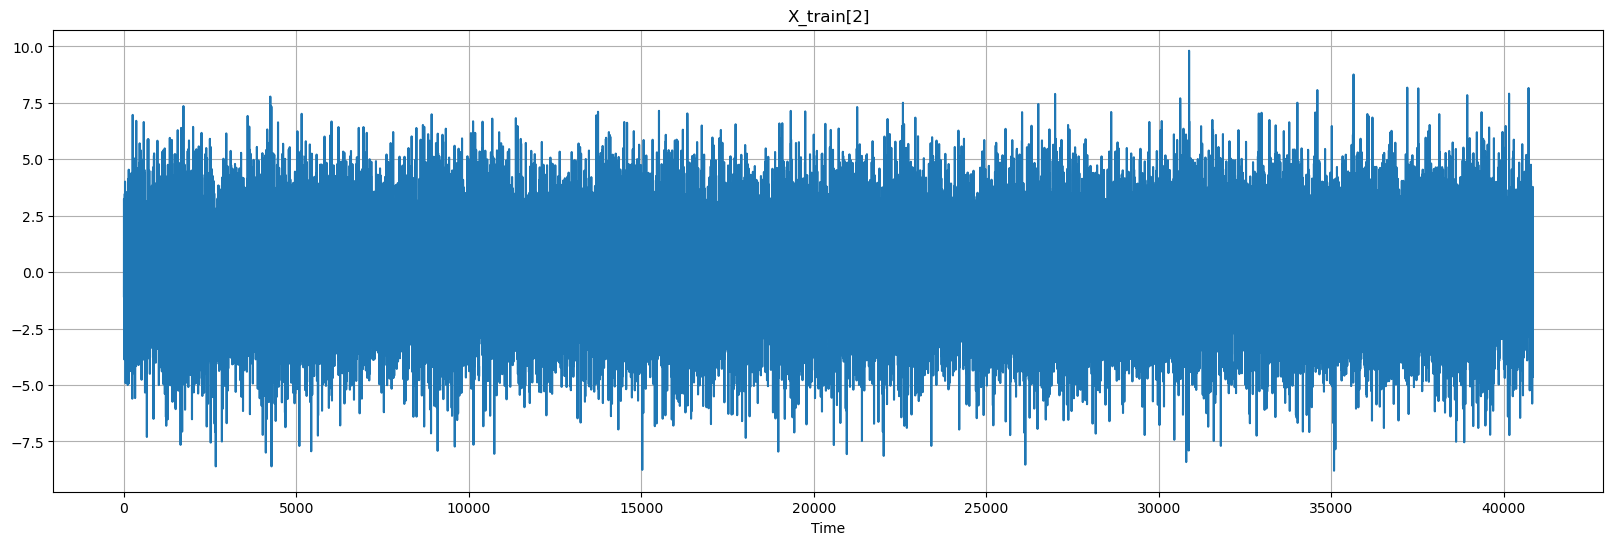

In [21]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(signal)
ax.grid(True)
ax.set_title("X_train[2]")
ax.set_xlabel('Time')
plt.show()

Let's plot the spectrogram : we can see 10 pairs, separated by silences, and an added noise whose frequency varies as a sine.

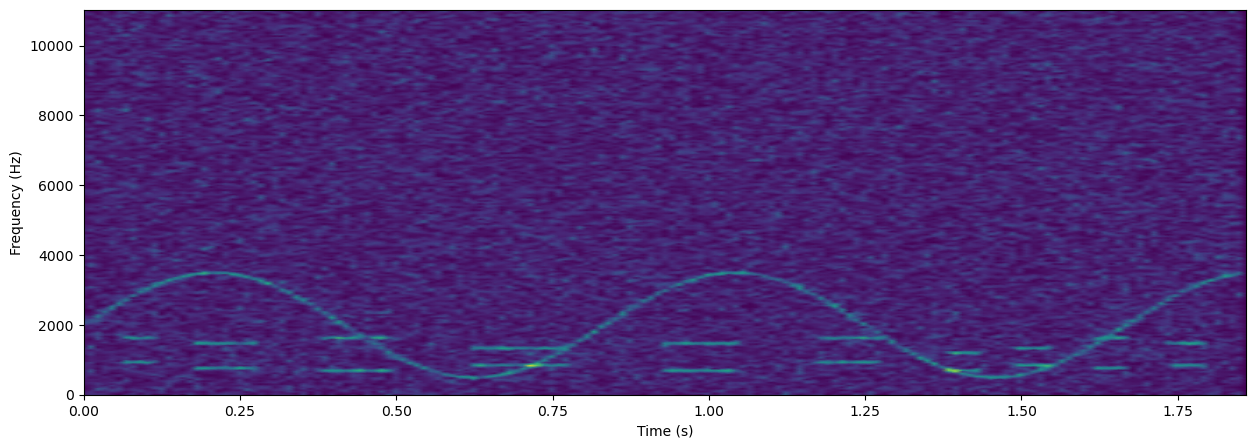

In [72]:
from scipy.signal import stft
FREQUENCY = 22050

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=500, noverlap=None)

fig, ax = fig_ax()
ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

The number of points per segment used to compute the STFT is a first hyperparameter

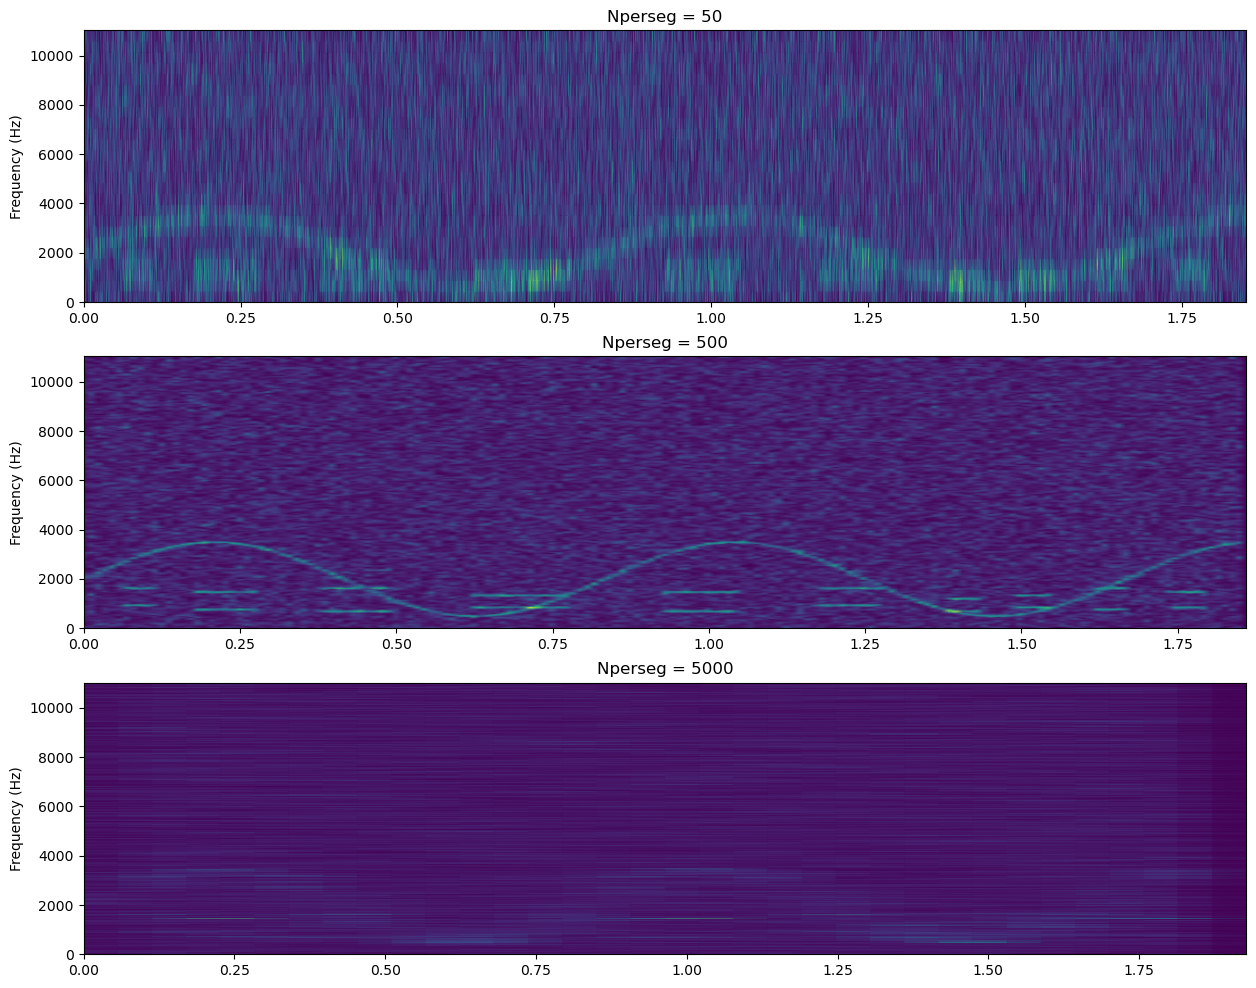

In [78]:
list_nperseg = [50,500,5000]

fig, axs = plt.subplots(nrows=len(list_nperseg), ncols=1, figsize=(15, 4*len(list_nperseg)))
for i, nperseg in enumerate(list_nperseg):
    f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=nperseg, noverlap=None)
    axs[i].pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
    # axs[i].set_xlabel("Time (s)")
    axs[i].set_title(f'Nperseg = {nperseg}')
    _ = axs[i].set_ylabel("Frequency (Hz)")

We can use a change-point detection algorithm, with an unknown number $K$ of changes, and a BIC criterion to find out the penalty $\beta$

In [80]:
modules = np.abs(Zxx)
modules.shape

(2501, 18)

In [81]:
zxx_sample = modules[:,3]

In [82]:
zxx_sample

array([0.01949185, 0.01554109, 0.00796204, ..., 0.03413963, 0.0554332 ,
       0.05660297])

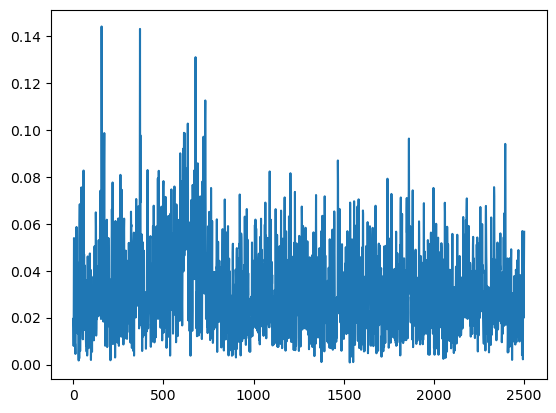

In [85]:
plt.plot(zxx_sample)

In [86]:
f.shape

(2501,)

# Question 2

In [ ]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

# Question 3

# Question 4

# Question 5

# Question 6

# Question 7